In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import astropy.units as u
from astropy.coordinates import AltAz, SkyCoord
from astropy.coordinates import EarthLocation
from astropy.coordinates.angles import Angle

from astropy.time import Time
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from fpipe.utils import coord

In [3]:
_Lon = (106. + 51./60. + 24.0/3600.) * u.deg
_Lat = (25. + 39./60. + 10.6/3600.) * u.deg
_Location = EarthLocation.from_geodetic(_Lon, _Lat)


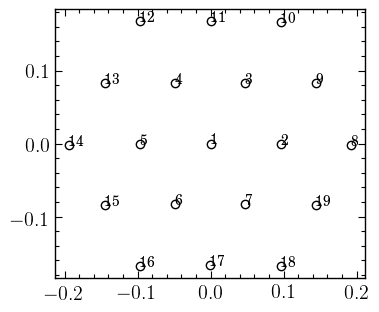

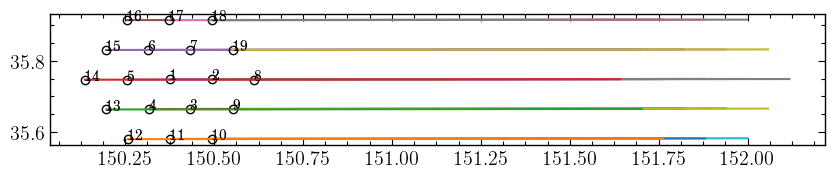

In [4]:
'''
Test coord
'''
# assume some time and pointing
time = Time('2020-05-05 12:00:00') + np.linspace(0, 0.1, 100) * u.hour
alt0  = 80
az0   = 0. #48.

# get pointing of each beam
az, alt, ra, dec = coord.get_pointing_any_scan(time.unix, alt0, az0, feed_rotation=0)

# plot beam coord in ant. coord
#print az, alt
fig = plt.figure(figsize=[4, 4])
ax  = fig.add_subplot(111)
x, y = coord.project_to_antenna_coord(alt, az, alt[:,0], az[:,0])
for i in range(19):
    ax.plot(x[0, i], y[0, i], 'ko', mfc='none')
    ax.text(x[0, i], y[0, i], '%2d'%(i+1))
ax.set_aspect('equal')
#ax.set_xlim(-0.25, 0.25)
#ax.set_ylim(-0.25, 0.25)

# plot beam coord in RA Dec coord
# with alt0 lower than 80 and az!=0 or 180, beams in the same line are scanning different dec
fig = plt.figure(figsize=[10, 6])
ax  = fig.add_subplot(111)
for i in range(19):
    ax.plot(ra[:, i], dec[:, i])
    ax.plot(ra[0, i], dec[0, i], 'ko', mfc='none')
    ax.text(ra[0, i], dec[0, i], '%2d'%(i+1))

ax.set_aspect('equal')

In [5]:
def simulate_cal_scans(cal, obstime, ddec_list, scan_time = 140. * u.second, 
                       loading_time = 5 * u.minute, figsize=[15, 14]):
    
    '''
    cal         : the calibrator, should be an astropy.coord.SkyCoord object;
    ddec_list   : The dec separation for each drift scan;
    scan_time   : drift scan time duration;
    loading_time: time duration for switching targets;
    
    '''

    # find the source meridian transit time. The drift scan shuold be performed 
    # around the meridian transit time.
    #
    #_obstime = Time('2020-05-06 6:00:00') + np.linspace(0, 18, 100) * u.hour
    _obstime = Time(obstime) + np.linspace(0, 24, 100) * u.hour
    time_transit = coord._get_meridian_transit_time(_obstime, _Location, cal)
    _obstime = time_transit + np.linspace(-0.18, 0.18, 100) * u.hour
    time_transit = coord._get_meridian_transit_time(_obstime, _Location, cal)
    print 'Cal meridian transit time: %s'%time_transit.fits

    # loading_time is the time duration for beam re-position, need to check with observer.
    #loading_time = 5 * u.minute

    n_scans = len(ddec_list)
    total_time = n_scans * scan_time + (n_scans - 1) * loading_time
    
    start_time = time_transit - total_time / 2.
    print 'Start time around %s'%(start_time).fits
    
    fwhm = 2.9 / 60. / (2. * np.log(2.))**0.5 # this is actually the sigma.
    
    n_col = 5
    n_row = int(np.ceil(n_scans / float(n_col)))
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(n_row , n_col, left=0.08, bottom=0.08, right=0.95,
                           top=0.95, wspace=0.0, hspace=0.0)
    
    fig2, ax2 = coord.beam_axes()
    close_points = np.ones(19) * 1.e9

    dt = scan_time + loading_time
    print '-'*100
    print '%3s%29s%30s%35s'%('#', 'Time', 'Beam1 Pointing Alt Az', 'Beam1 Pointing RA Dec (J2000)')
    for ii, ddec in enumerate(ddec_list):
        
        ax = fig.add_subplot(gs[ii//n_col, ii - ii//n_col * n_col])
    
        time = Time(start_time) + np.arange(0, scan_time.to(u.second).value, 1) * u.second + dt * ii
        mid = len(time) // 2
        #print mid, len(time)
    
        #print '%3d %3dh%2dm%6.4fs  %3dd%2dm%6.4fs '%((ii, ) + cal_ra.hms + cal_dec.dms)
        
        # create observer and convert the calibrator sky coordinate to local observer coordinate
        obs = AltAz(location=_Location, obstime = time)
        cal_altaz = cal.transform_to(obs)
        cal_alt, cal_az = cal_altaz.alt.deg, cal_altaz.az.deg
        cal_az[cal_az>180] -= 360.
        cal_az[cal_az<-180] += 360.
        
        
        # pointing offset 
        p_ra  = cal.ra #Angle('13h31m08.287984s')
        p_dec = cal.dec + ddec * u.deg #Angle('30d30m32.958850s')
        p = SkyCoord(p_ra, p_dec)
        #print p.dec
        p_altaz = p.transform_to(obs)
        p_alt, p_az = p_altaz.alt.deg, p_altaz.az.deg
        p_az[p_az>180] -= 360
        p_az[p_az<-180] += 360
        alt0 = p_alt[mid]
        az0  = p_az[mid]
        az, alt, ra, dec = coord.get_pointing_any_scan(time.unix, alt0, az0, feed_rotation=0)
        
        ra_c  = Angle(ra[0, 0], u.deg)
        dec_c = Angle(dec[0, 0], u.deg)
        az_c  = Angle(az[0, 0], u.deg)
        alt_c = Angle(alt[0, 0], u.deg)
        print '%3d %s, (%3dd%2dm%4.4fs, %3dd%2dm%4.2fs);'%((ii, time[0].fits) + alt_c.dms + az_c.dms)\
             +' (%3dh%2dm%4.2fs, %3dd%2dm%4.2fs)'%(ra_c.hms + dec_c.dms)
        
        # get the position of calibrator relative to the center beam in obs local coordinate.
        cal_x, cal_y = coord.project_to_antenna_coord(cal_alt, cal_az, alt0, az0)
        # get the position of each beam relative to center beam, in observer local coordinate.
        x, y = coord.project_to_antenna_coord(alt, az, alt0, az0)

        for i in range(19):
            #ax.plot(x[i], y[i], 'ko', mfc='none')
            ax.add_artist(plt.Circle((x[0, i], y[0, i]), fwhm/2., color='k', fill=False))
            ax.add_artist(plt.Circle((x[0, i], y[0, i]), fwhm, color='k', linestyle=':', fill=False))
            ax.text(x[0, i], y[0, i], '%d'%(i+1), ha='center', va='center', size=8)
        
            #ax2[i].scatter(ra[:, i], dec[:, i], s=5, c='r', edgecolors='none', alpha=0.1)
            cal_xi, cal_yi = coord.project_to_antenna_coord(cal_alt, cal_az, alt[0, i], az[0, i])
            ax2[i].plot(cal_xi, cal_yi, 'r.', ms=2)
            _d = (cal_xi**2 + cal_yi**2) ** 0.5
            if _d.min() < close_points[i]: close_points[i] = _d.min()
            #ax2[i].plot(cal_xi[0], cal_yi[0], 'go')
            #ax2[i].text(cal_xi[0], cal_yi[0], '%2d'%ii)
    
        ax.text(-0.25, 0.25, 'Az0, Alt0 = %5.2f, %5.2f' % (az0, alt0))
    
        ax.plot(cal_x, cal_y, 'r.', ms=2)
        ax.plot(cal_x[0], cal_y[0], 'go')
        ax.text(cal_x[0], cal_y[0], '%2d'%ii)
        ax.set_aspect('equal')
        ax.set_xlim(-0.3, 0.3)
        ax.set_ylim(-0.3, 0.3)
        
        if ii // n_col == n_row - 1:
            ax.set_xlabel(r'H $[^\circ]$')
        else:
            ax.set_xticklabels([])
        if ii - ii//n_col * n_col == 0:
            ax.set_ylabel(r'V $[^\circ]$')
        else:
            ax.set_yticklabels([])
        #ax.set_title('Ant. Coord.')

    for i, _ax in enumerate(ax2):
        #_ax.plot(cal_ra.deg, cal_dec.deg, 'kx', zorder=1000)
        _ax.add_artist(plt.Circle((0, 0), fwhm/2., color='k', fill=False))
        _ax.add_artist(plt.Circle((0, 0), fwhm, color='k', linestyle=':', fill=False))
        #_ax.text(0, 0, '%d'%(i+1), ha='center', va='center', size=12)
        _ax.plot(0, 0, 'k.')
        _ax.text(-2.6*fwhm, 2.5*fwhm, 'B%02d [%f arcmin]'%(i+1, close_points[i] * 60.), 
                 ha='left', va='center', size=10)
        #_ax.legend(loc=1)
        _ax.set_aspect('equal')
        #_ax.set_xlim(xmin=cal_ra.deg - 0.5, xmax=cal_ra.deg + 0.5)
        #_ax.set_ylim(ymin=cal_dec.deg - 0.5, ymax=cal_dec.deg + 0.5)
        _ax.set_xlim(xmin=-3*fwhm, xmax=3*fwhm)
        _ax.set_ylim(ymin=-3*fwhm, ymax=3*fwhm)
        _ax.set_xticklabels([])
        _ax.set_yticklabels([])

Cal meridian transit time: 2020-05-08T15:16:58.909(UTC)
Start time around 2020-05-08T15:01:28.909(UTC)
----------------------------------------------------------------------------------------------------
  #                         Time         Beam1 Pointing Alt Az      Beam1 Pointing RA Dec (J2000)
  0 2020-05-08T15:01:28.909(UTC), ( 84d27m26.8591s,  33d19m46.91s); ( 13h29m37.95s,  30d20m37.40s)
  1 2020-05-08T15:08:28.909(UTC), ( 85d 4m32.0232s,  18d 3m44.80s); ( 13h29m37.95s,  30d25m35.66s)
  2 2020-05-08T15:15:28.909(UTC), ( 85d14m46.1208s,   0d 7m32.33s); ( 13h29m37.95s,  30d30m33.92s)
  3 2020-05-08T15:22:28.909(UTC), ( 84d55m29.9422s, -17d-13m-59.90s); ( 13h29m37.95s,  30d35m32.18s)
  4 2020-05-08T15:29:28.909(UTC), ( 84d11m38.9412s, -31d-16m-57.01s); ( 13h29m37.95s,  30d40m30.44s)


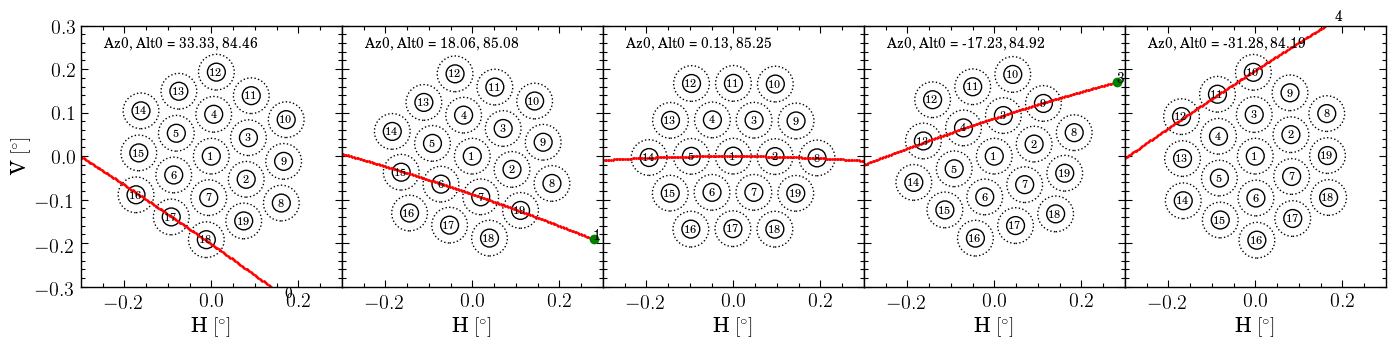

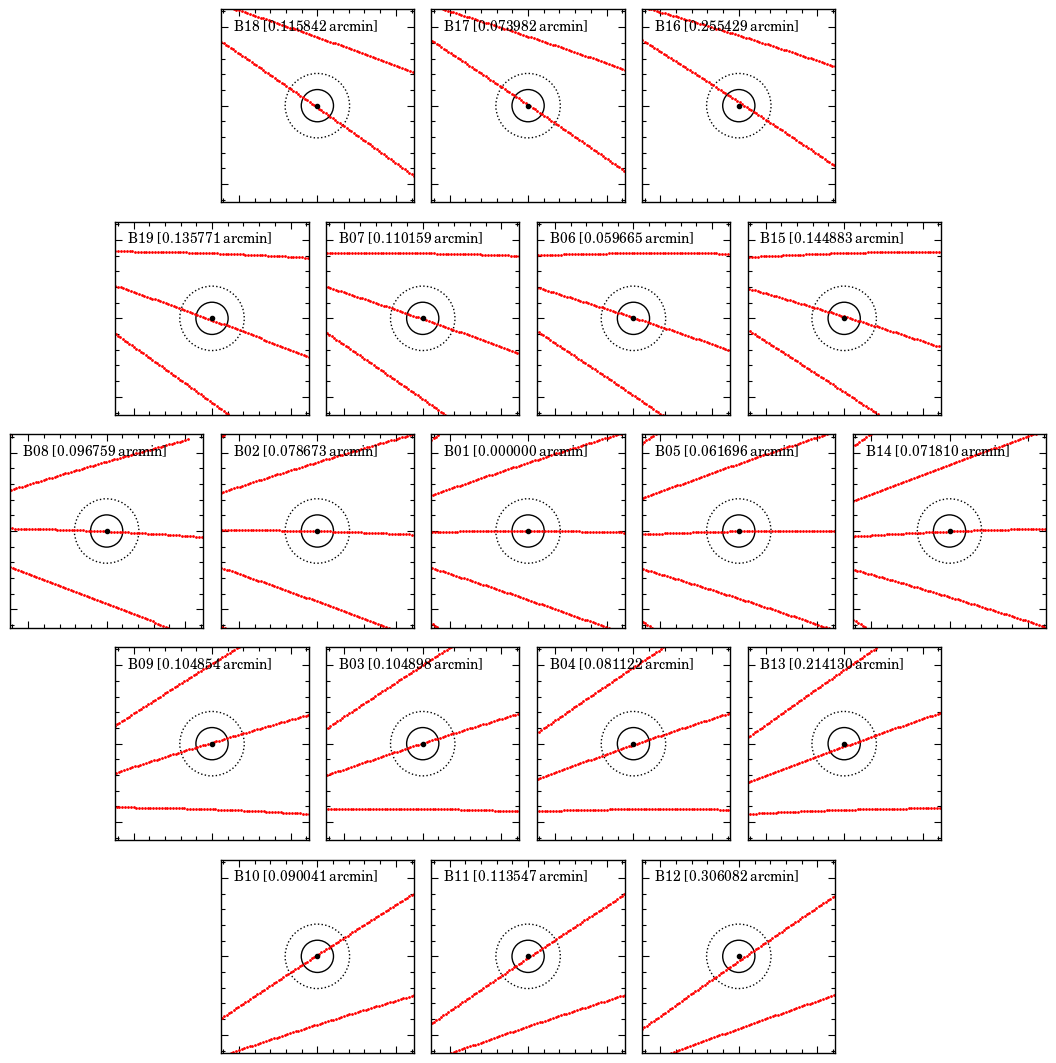

In [6]:
# simulate calibrator scans. 3C286
cal_ra  = Angle('13h31m08.287984s')
cal_dec = Angle('30d30m32.958850s') #+ ddec * u.deg
cal = SkyCoord(cal_ra, cal_dec)

#print cal.dec

fwhm = 2.9 / 60. / (2. * np.log(2.))**0.5 # this is actually the sigma.
#line_space = (Angle('0d9m55.95s') / 2.).deg
line_space = Angle(4.971, u.arcmin).deg # according to latest measurements.
ddec_list = [ -2*line_space, -line_space, 0, line_space, 2*line_space]

obstime = '2020-05-08 6:00:00'
simulate_cal_scans(cal, obstime, ddec_list, 
                   scan_time = 180. * u.second, 
                   loading_time = 4 * u.minute, 
                   figsize=(15, 3))

Cal meridian transit time: 2020-05-08T09:28:32.727(UTC)
Start time around 2020-05-08T09:13:02.727(UTC)
----------------------------------------------------------------------------------------------------
  #                         Time         Beam1 Pointing Alt Az      Beam1 Pointing RA Dec (J2000)
  0 2020-05-08T09:13:02.727(UTC), ( 86d36m52.5964s,  67d37m0.25s); (  7h39m55.46s,  26d56m46.52s)
  1 2020-05-08T09:20:02.727(UTC), ( 87d56m22.9442s,  49d24m49.70s); (  7h39m55.46s,  27d 1m44.78s)
  2 2020-05-08T09:27:02.727(UTC), ( 88d35m14.2015s,   0d 2m17.46s); (  7h39m55.46s,  27d 6m43.04s)
  3 2020-05-08T09:34:02.727(UTC), ( 87d49m52.4961s, -46d 0m-57.55s); (  7h39m55.46s,  27d11m41.30s)
  4 2020-05-08T09:41:02.727(UTC), ( 86d29m5.2753s, -62d-32m-48.95s); (  7h39m55.46s,  27d16m39.56s)


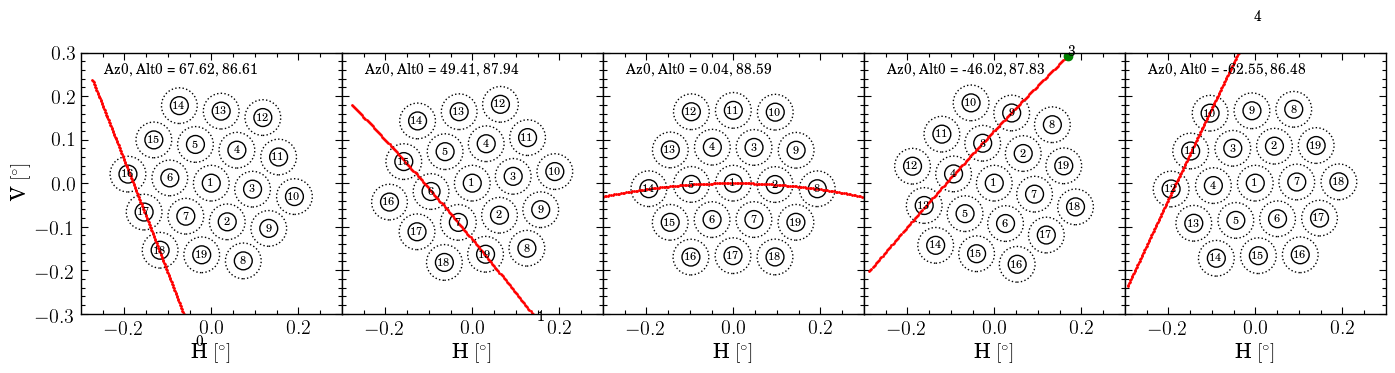

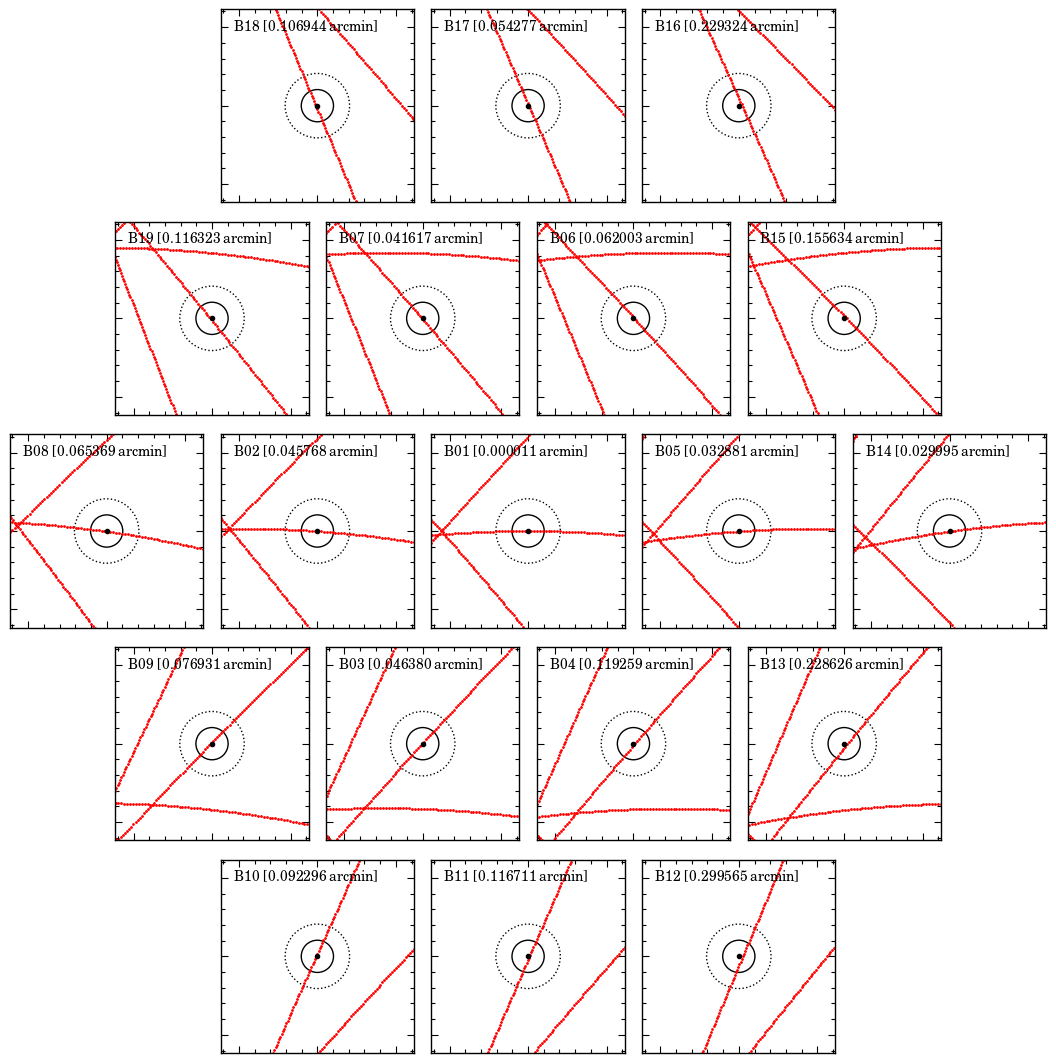

In [7]:
# simulate calibrator scans. B2 0738
cal_ra  = Angle('07h41m25.7328s')
cal_dec = Angle('27d06m45.392s')
cal = SkyCoord(cal_ra, cal_dec)

fwhm = 2.9 / 60. / (2. * np.log(2.))**0.5 # this is actually the sigma.
#line_space = (Angle('0d9m55.95s') / 2.).deg
line_space = Angle(4.971, u.arcmin).deg # according to latest measurements.
ddec_list = [ -2*line_space, -line_space, 0, line_space, 2*line_space]

obstime = '2020-05-08 6:00:00'
simulate_cal_scans(cal, obstime, ddec_list,
                   scan_time = 180. * u.second,
                   loading_time = 4 * u.minute, 
                   figsize=(15, 3))

Cal meridian transit time: 2020-05-06T15:24:58.909(UTC)
Start time around 2020-05-06T13:55:48.909(UTC)
----------------------------------------------------------------------------------------------------
  #                         Time         Beam1 Pointing Alt Az      Beam1 Pointing RA Dec (J2000)
  0 2020-05-06T13:55:48.909(UTC), ( 70d 2m21.4035s,  71d48m3.96s); ( 13h29m58.03s,  30d18m9.97s)
  1 2020-05-06T14:03:08.909(UTC), ( 71d36m25.3722s,  71d 0m57.33s); ( 13h29m58.03s,  30d19m23.86s)
  2 2020-05-06T14:10:28.909(UTC), ( 73d 9m42.2145s,  69d56m1.92s); ( 13h29m58.03s,  30d21m51.65s)
  3 2020-05-06T14:17:48.909(UTC), ( 74d42m27.0327s,  68d37m15.35s); ( 13h29m58.03s,  30d23m5.54s)
  4 2020-05-06T14:25:08.909(UTC), ( 76d11m43.7077s,  66d19m52.88s); ( 13h29m58.03s,  30d33m3.90s)
  5 2020-05-06T14:32:28.909(UTC), ( 77d41m37.5038s,  64d 2m28.62s); ( 13h29m58.03s,  30d34m17.79s)
  6 2020-05-06T14:39:48.909(UTC), ( 79d 8m56.0990s,  60d54m30.24s); ( 13h29m58.03s,  30d36m45.57s)
  7 2020-0

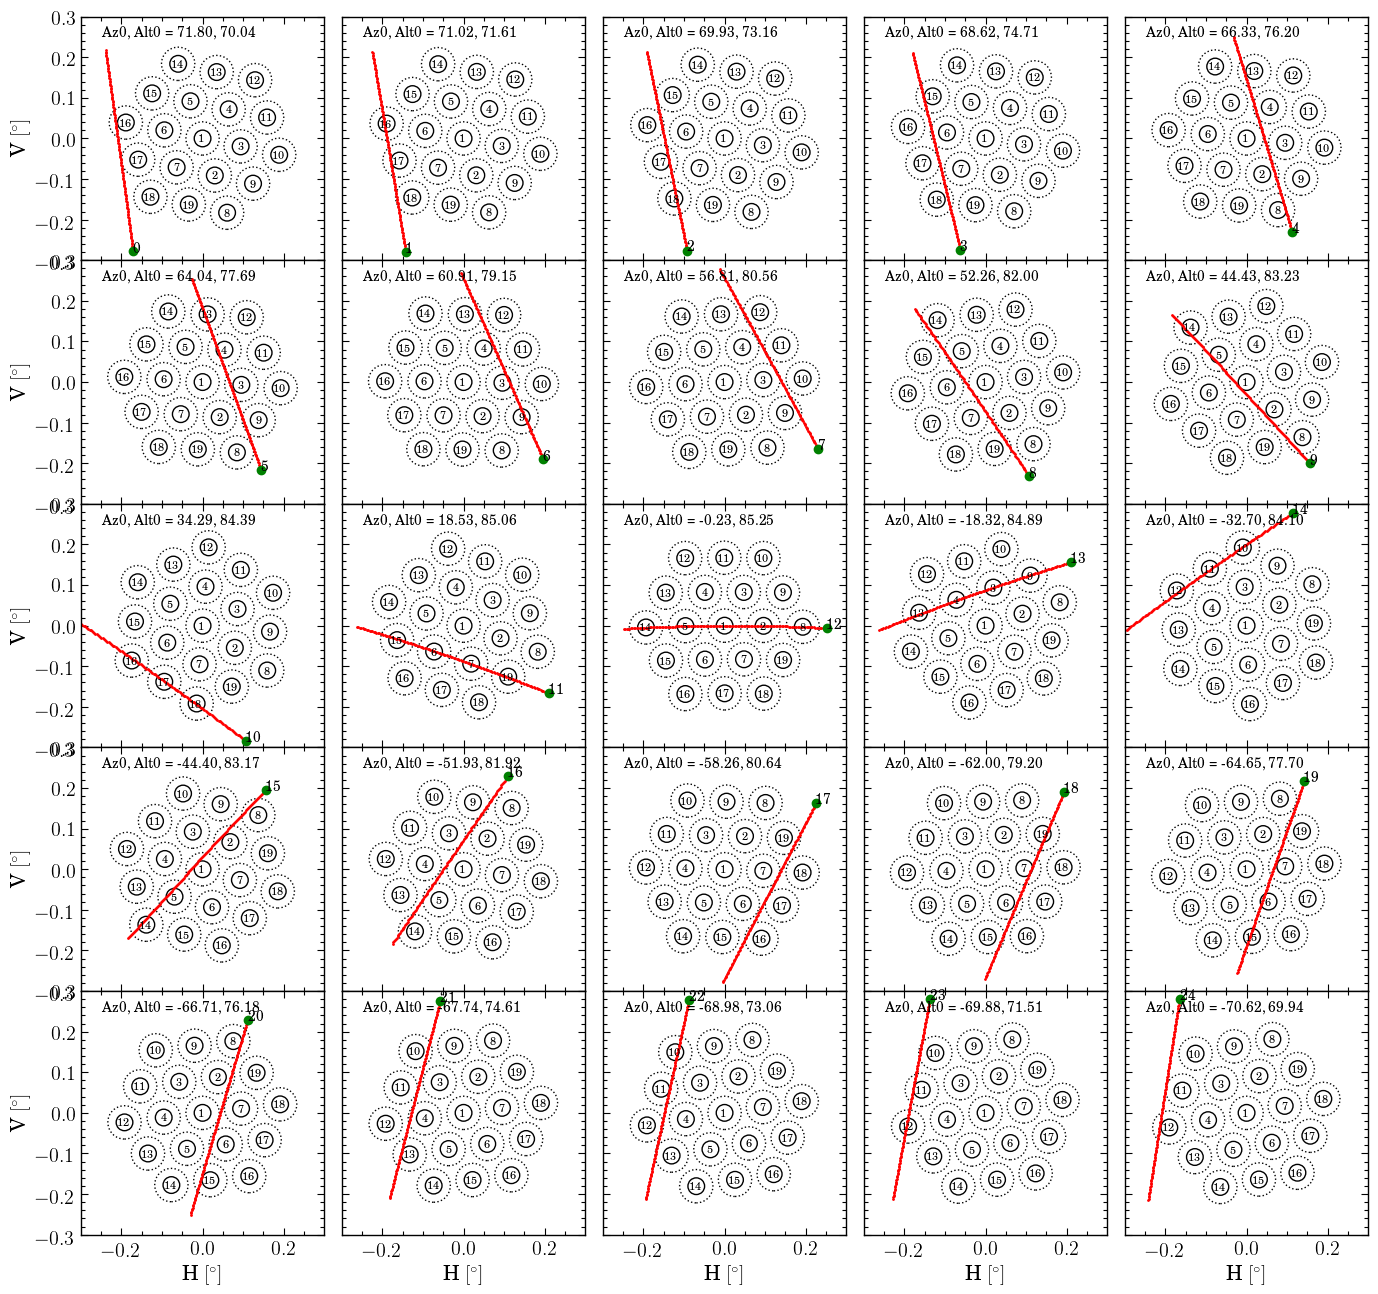

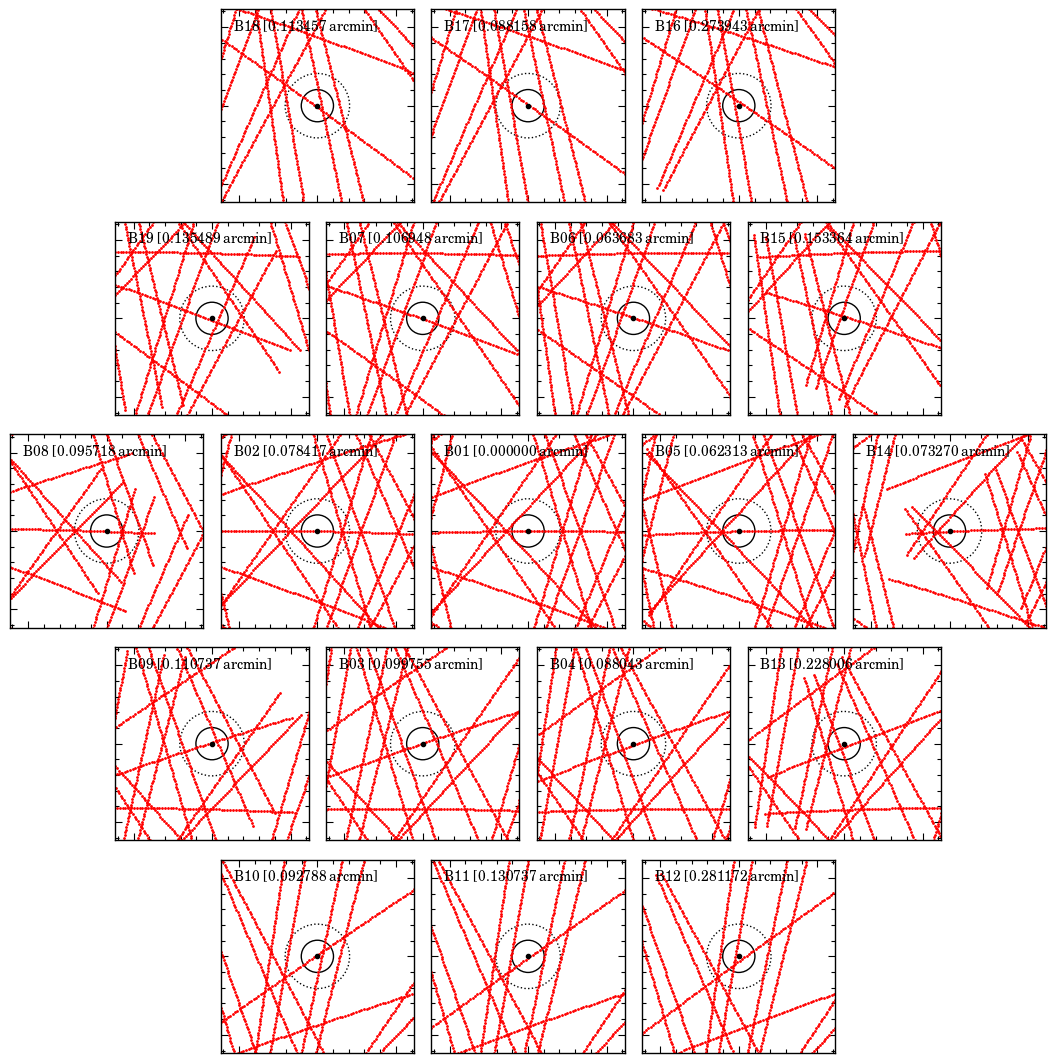

In [8]:
# simulate calibrator scans. 3C286
cal_ra  = Angle('13h31m08.287984s')
cal_dec = Angle('30d30m32.958850s') #+ ddec * u.deg
cal = SkyCoord(cal_ra, cal_dec)

# Dec shift for beam scanning. 
#
# line_space: The space between different beam line is 4.96625 arcmin, according to the beam position.
# See calculation in the last block of this notebook
#
# line_shift: Each beam line is scanned for 5 times with shift of beam size fwhm/2/sqrt(2ln2)
#
# ddec_list: The order of the scanning is special designed to have better coverage for each beam.
#
fwhm = 2.9 / 60. / (2. * np.log(2.))**0.5 # this is actually the sigma.
line_space = (Angle('0d9m55.95s') / 2.).deg
line_shift = fwhm / 2.
ddec_list = [
    #-2*line_space - 3.*line_shift,
    -2*line_space - 2.*line_shift, 
    -2*line_space - 1.*line_shift,
    #-2*line_space, 
    -2*line_space + 1.*line_shift,
    -2*line_space + 2.*line_shift,
    
    line_space - 2.*line_shift, 
    line_space - 1.*line_shift,
    #line_space, 
    line_space + 1.*line_shift,
    line_space + 2.*line_shift,
    
    - 2.*line_shift, 
    - 1.*line_shift,
    
    -2*line_space,
    -line_space,
    0, 
    line_space,
    2*line_space,
    
    + 1.*line_shift,
    + 2.*line_shift,
    
    -line_space - 2.*line_shift, 
    -line_space - 1.*line_shift,
    #line_space,
    -line_space + 1.*line_shift,
    -line_space + 2.*line_shift,
    

    2*line_space - 2.*line_shift, 
    2*line_space - 1.*line_shift,
    #2*line_space,
    2*line_space + 1.*line_shift,
    2*line_space + 2.*line_shift,
    #2*line_space + 3.*line_shift,
    ]

obstime = '2020-05-06 6:00:00'
simulate_cal_scans(cal, obstime, ddec_list, loading_time = 5 * u.minute)